In [1]:
!pip install eagleSqlTools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import eagleSqlTools as sql
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as col
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec

con = sql.connect("vwg533", password = "FZtn087h")

In [ ]:
sim_name = 'RefL0100N1504'
sim_size = 100.

Query_IDs = "SELECT \
            (MAG.u_nodust - MAG.r_nodust) as u_minus_r, \
            log10(AP.Mass_Star) as mass, \
            (AP.SFR/AP.Mass_Star) as ssfr, \
            SH.GalaxyID as id \
           FROM \
            %s_SubHalo as SH, \
            %s_Magnitudes as MAG, \
            %s_Aperture as AP \
           WHERE \
            SH.SnapNum = 28 and \
            SH.SubGroupNumber = 0 and \
            AP.Mass_Star > 1.0e9 and \
            AP.ApertureSize = 30 and \
            SH.GalaxyID = MAG.GalaxyID and \
            SH.GalaxyID = AP.GalaxyID"%(sim_name, sim_name, sim_name)

Data_IDs = sql.execute_query(con, Query_IDs)

In [ ]:
for i in range(len(Data_IDs['id'])):
  print('ID:' ,Data_IDs['id'][i])
  print('u-r:' ,Data_IDs['u_minus_r'][i])
  print('Mass:' ,Data_IDs['mass'][i])
  print('sSFR:' ,Data_IDs['ssfr'][i])
  print('')

Streaming output truncated to the last 5000 lines.
ID: 9805592
u-r: 1.4886036
Mass: 10.277714164937553
sSFR: 5.6523026e-11

ID: 9897265
u-r: 1.659689
Mass: 10.308562383918048
sSFR: 3.213921e-11

ID: 9909258
u-r: 1.175396
Mass: 10.30474360771978
sSFR: 1.3896283e-10

ID: 9934326
u-r: 1.7402115
Mass: 10.497834703069003
sSFR: 2.7529043e-11

ID: 9964678
u-r: 1.4901905
Mass: 9.966200040910893
sSFR: 5.4236907e-11

ID: 10005161
u-r: 1.3105946
Mass: 10.232009466498509
sSFR: 8.884996e-11

ID: 10035406
u-r: 1.0904121
Mass: 9.866292640871599
sSFR: 1.9150852e-10

ID: 10042583
u-r: 2.204874
Mass: 10.054877735733363
sSFR: 6.658251e-12

ID: 10080501
u-r: 1.6042213
Mass: 10.224979059317514
sSFR: 4.241344e-11

ID: 9383525
u-r: 2.337738
Mass: 10.3893952939169
sSFR: 3.5252226e-12

ID: 9621245
u-r: 1.8207226
Mass: 10.507162353016717
sSFR: 2.4168325e-11

ID: 9709796
u-r: 1.4601746
Mass: 10.183454832296233
sSFR: 6.494262e-11

ID: 8926834
u-r: 0.99136734
Mass: 10.055371676219835
sSFR: 2.5858057e-10

ID: 92620

In [15]:
sim_name = 'RefL0100N1504'
sim_size = 100.
galaxy_id_1 = 9383525 # Red
galaxy_id_2 = 9709796 # Blue

# Red
Query_1 = "SELECT \
            gal.Redshift as z, \
            gal.MassType_Star as mass, \
            gal.MassType_DM as halo, \
            gal.MassType_BH as bh, \
            gal.StarFormationRate as sfr \
          FROM \
            %s_Subhalo as gal, \
            %s_Subhalo as ref \
          WHERE \
            ref.GalaxyID=%s and \
            ((gal.SnapNum > ref.SnapNum and ref.GalaxyID \
            between gal.GalaxyID and gal.TopLeafID) or \
            (gal.SnapNum <= ref.SnapNum and gal.GalaxyID \
            between ref.GalaxyID and ref.TopLeafID)) \
          ORDER BY \
            gal.Redshift"%(sim_name, sim_name, galaxy_id_1)

# Blue
Query_2 = "SELECT \
            gal.Redshift as z, \
            gal.MassType_Star as mass, \
            gal.MassType_DM as halo, \
            gal.MassType_BH as bh, \
            gal.StarFormationRate as sfr \
          FROM \
            %s_Subhalo as gal, \
            %s_Subhalo as ref \
          WHERE \
            ref.GalaxyID=%s and \
            ((gal.SnapNum > ref.SnapNum and ref.GalaxyID \
            between gal.GalaxyID and gal.TopLeafID) or \
            (gal.SnapNum <= ref.SnapNum and gal.GalaxyID \
            between ref.GalaxyID and ref.TopLeafID)) \
          ORDER BY \
            gal.Redshift"%(sim_name, sim_name, galaxy_id_2)

Data_1 = sql.execute_query(con, Query_1)
Data_2 = sql.execute_query(con, Query_2)
r = len(Data_1['z'])
b = len(Data_2['z'])

In [4]:
def log_with_zeros(data): # Replaces zeroes with the smallest nonzero value.
  logs = np.empty(len(data))
  for i in range(0, len(data)):
    if data[i] == 0.0:
      logs[i] = 99.
    else:
      logs[i] = np.log10(data[i])
  m = logs.min()
  for j in range(0, len(logs)):
    if logs[j] == 99.:
      logs[j] = m
    else:
      logs[j] = logs[j]
  return logs

def divide_with_zeros(n, d):
  res = np.empty(len(n))
  for i in range(len(n)):
    if d[i] == 0:
      res[i] = 0
    else:
      res[i] = n[i]/d[i]
  return res

def remove_zeros(data):
  out = []
  for i in range(len(data)):
    if data[i] == 0:
      out = out
    else:
      out = out + [data[i]]
  return np.array(out)

In [5]:
Times = np.array([13.62, 13.53, 13.32, 13.25, 13.16, 13.04, 12.86, 12.75, 12.63, 12.46, 12.25, 12.01, 11.66, 11.16,
                  10.86, 10.53, 10.05, 9.49, 8.86, 7.93, 7.37, 6.71, 6.01, 5.19, 4.16, 3.23, 2.29, 1.24, 0.0]) # len = 29

In [6]:
sSFR_1 = divide_with_zeros(Data_1['sfr'], Data_1['mass']) * 10**9

r_snapnums = np.arange(29-len(Data_1['mass']), 29)[::-1]
LogMasses = log_with_zeros(Data_1['mass'])
r_medians = []
Range = 0.1

for i in range(len(LogMasses)):
  GalMass = LogMasses[i]
  Max = 10**(GalMass+Range)
  Min = 10**(GalMass-Range)
  MyQuery = "SELECT \
            log10(AP.Mass_Star) as mass, \
            (AP.SFR/AP.Mass_Star) as ssfr \
           FROM \
            %s_SubHalo as SH, \
            %s_Aperture as AP \
           WHERE \
            SH.SnapNum = %s and \
            SH.SubGroupNumber = 0 and \
            AP.Mass_Star < %s and \
            AP.Mass_Star > %s and \
            AP.ApertureSize = 30 and \
            SH.GalaxyID = AP.GalaxyID"%(sim_name, sim_name, r_snapnums[i], Max, Min)
  Galaxies = sql.execute_query(con, MyQuery)
  r_medians = r_medians + [np.median(Galaxies['ssfr'])]
  #print(Galaxies['mass'])
r_medians = np.array(r_medians) * 10**9 # Median sSFR within mass range from snapnum=28 to minimum possible snapnum /Gyr^-1
print(r_medians)
print(len(sSFR_1) - len(r_medians))

[4.01981920e-02 5.31687819e-02 6.35254557e-02 7.97649724e-02
 9.19608278e-02 1.15850496e-01 1.37841252e-01 1.78180817e-01
 2.42899811e-01 3.91965238e-01 5.34297717e-01 6.74244161e-01
 8.18581036e-01 9.62511848e-01 1.13662058e+00 1.30385924e+00
 1.63493064e+00 2.06898076e+00 2.36445352e+00 2.23503172e+00
 2.19499441e+00 1.30591238e+00 1.37210709e+00 1.15410548e+00
 8.79777495e+00 4.15420516e+01 4.54721416e+01]
0


In [7]:
sSFR_2 = divide_with_zeros(Data_2['sfr'], Data_2['mass']) * 10**9

b_snapnums = np.arange(29-len(Data_2['mass']), 29)[::-1]
LogMasses = log_with_zeros(Data_2['mass'])
b_medians = []
Range = 0.1

for i in range(len(LogMasses)):
  GalMass = LogMasses[i]
  Max = 10**(GalMass+Range)
  Min = 10**(GalMass-Range)
  MyQuery = "SELECT \
            log10(AP.Mass_Star) as mass, \
            (AP.SFR/AP.Mass_Star) as ssfr \
           FROM \
            %s_SubHalo as SH, \
            %s_Aperture as AP \
           WHERE \
            SH.SnapNum = %s and \
            SH.SubGroupNumber = 0 and \
            AP.Mass_Star < %s and \
            AP.Mass_Star > %s and \
            AP.ApertureSize = 30 and \
            SH.GalaxyID = AP.GalaxyID"%(sim_name, sim_name, b_snapnums[i], Max, Min)
  Galaxies = sql.execute_query(con, MyQuery)
  b_medians = b_medians + [np.median(Galaxies['ssfr'])]
  #print(Galaxies['mass'])
b_medians = np.array(b_medians) * 10**9 # Median sSFR within mass range from snapnum=28 to minimum snapnum of merger tree /Gyr^-1
print(b_medians)
print(len(sSFR_2) - len(b_medians))

[ 0.04881939  0.06399192  0.07812544  0.11235818  0.13887723  0.19219268
  0.24032967  0.29200656  0.34976183  0.42002143  0.51263505  0.63041777
  0.76221307  0.95513286  1.06206643  1.20850352  1.42432355  1.65180647
  1.41073309  1.34672351  0.96267683  0.          0.          0.
 41.7631405  43.31906922 46.69619713]
0


In [8]:
r_diffs = log_with_zeros(sSFR_1) - log_with_zeros(r_medians)
print(r_diffs)

b_diffs = log_with_zeros(sSFR_2) - log_with_zeros(b_medians)
print(b_diffs)

[-1.07042308e+00 -1.39119375e+00 -1.56867938e+00 -2.17630326e+00
 -2.23809391e+00 -1.49415444e+00 -5.22093233e-02  3.70864511e-01
  6.14932066e-01  1.53300774e-01  3.06396776e-02 -1.15699860e-01
  1.02993007e-01  9.29156615e-04 -1.16075636e-01 -1.03774021e-01
 -7.94088730e-02 -2.97738217e-01 -1.01152698e-01 -2.01362508e-01
  6.26733857e-01  3.84510408e-01 -7.16167948e-01 -1.26186151e-02
  3.78433829e-01 -1.21836760e-01 -4.93223645e+00]
[ 1.03338650e-01  4.31986031e-02  2.79485750e-01  7.55636215e-02
  1.94253961e-01  1.01775456e-02  3.80081532e-02 -4.24500715e-03
 -1.31744725e-01  1.55758369e-03  2.89178114e-01  9.93946506e-04
 -2.52766902e-01  5.92200539e-02 -2.09582196e-01 -2.87906066e-01
 -1.09152444e-01  1.33283377e-01  4.27633504e-01  5.64795964e-02
  1.82724880e-01  2.27645237e+00  1.84002369e+00  2.46158228e+00
 -2.11720166e-01 -2.84474809e+00 -2.87735049e+00]


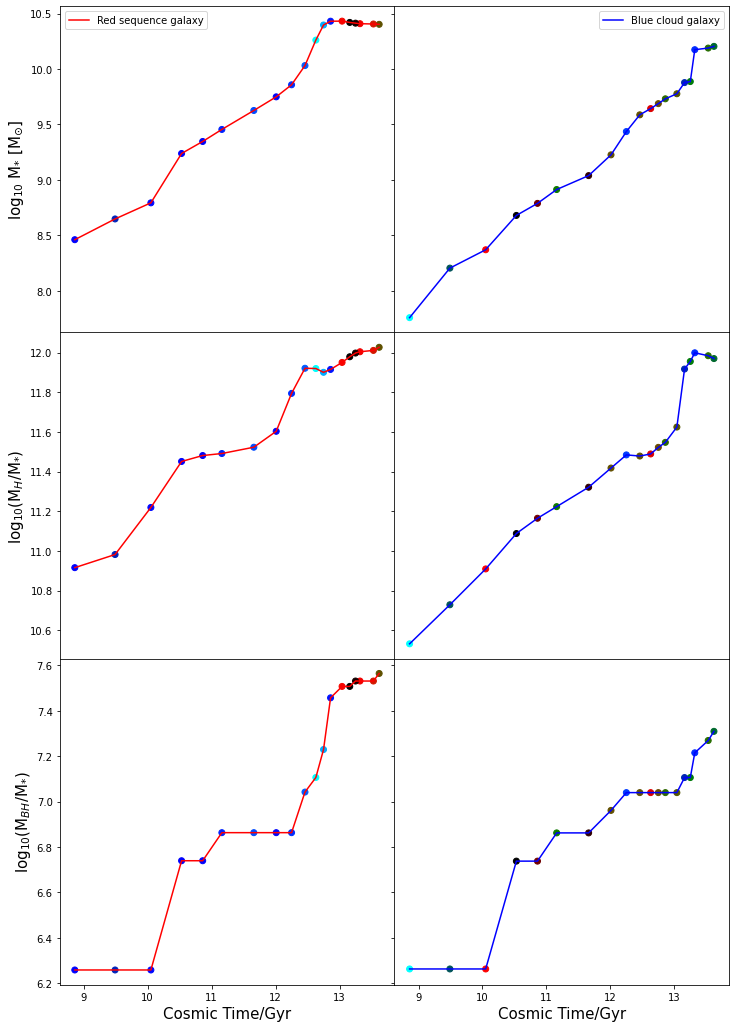

In [34]:
cvals = [-2, -1, 0, 1, 2]
colors = ["black","red","green","blue","cyan"]
norm = plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
cmap = col.LinearSegmentedColormap.from_list("", tuples)

final = 8

bh_red = remove_zeros(Data_1['bh'])
bh_blue = remove_zeros(Data_2['bh'])
r2 = len(bh_red) - len(Times[0:r-final])
b2 = len(bh_blue) - len(Times[0:b-final])

fig, (ax1, ax2, ax3) = plt.subplots(3, 2, figsize = (12,18), sharex = True, sharey = 'row')
ax1[0].plot(Times[0:r-final], log_with_zeros(Data_1['mass'])[0:-final], color = 'r', label = 'Red sequence galaxy')
ax1[1].plot(Times[0:b-final], log_with_zeros(Data_2['mass'])[0:-final], color = 'b', label = 'Blue cloud galaxy')
ax2[0].plot(Times[0:r-final], log_with_zeros(Data_1['halo'])[0:-final], color = 'r', label = 'Red sequence galaxy')
ax2[1].plot(Times[0:b-final], log_with_zeros(Data_2['halo'])[0:-final], color = 'b', label = 'Blue cloud galaxy')
ax3[0].plot(Times[0:r-final], log_with_zeros(bh_red)[0:-r2], color = 'r', label = 'Red sequence galaxy')
ax3[1].plot(Times[0:b-final], log_with_zeros(bh_blue)[0:-b2], color = 'b', label = 'Blue cloud galaxy')

ax1[0].scatter(Times[0:r-final], log_with_zeros(Data_1['mass'])[0:-final], c = r_diffs[0:-final], cmap = cmap)
ax1[1].scatter(Times[0:b-final], log_with_zeros(Data_2['mass'])[0:-final], c = b_diffs[0:-final], cmap = cmap)
ax2[0].scatter(Times[0:r-final], log_with_zeros(Data_1['halo'])[0:-final], c = r_diffs[0:-final], cmap = cmap)
ax2[1].scatter(Times[0:b-final], log_with_zeros(Data_2['halo'])[0:-final], c = b_diffs[0:-final], cmap = cmap)
ax3[0].scatter(Times[0:r-final], log_with_zeros(bh_red)[0:-r2], c = r_diffs[0:-final], cmap = cmap)
ax3[1].scatter(Times[0:b-final], log_with_zeros(bh_blue)[0:-b2], c = b_diffs[0:-final], cmap = cmap)

ax3[0].set_xlabel(r'Cosmic Time/Gyr', fontsize=15)
ax3[1].set_xlabel(r'Cosmic Time/Gyr', fontsize=15)
ax1[0].set_ylabel(r'log$_{10}$ M$_{*}$ [M$_{\odot}$]', fontsize=15)
ax2[0].set_ylabel(r'log$_{10}$(M$_{H}$/M$_{*}$)', fontsize=15)
ax3[0].set_ylabel(r'log$_{10}$(M$_{BH}$/M$_{*}$)', fontsize=15)
plt.subplots_adjust(hspace=.0, wspace=.0)
ax1[0].legend()
ax1[1].legend()
plt.savefig('Plot_2.jpeg')
plt.show()